In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

#..........................................
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import os



Using TensorFlow backend.


In [ ]:
def SAResNet(input_shape, classes):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((2, 2))(X_input)

    # Stage 1
    X = Conv2D(8, (3, 3), strides=(1, 1), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(1, 1))(X)
    print(X.shape)

    # Stage 2
    # First Residual block
    X = Conv2D(16, (3, 3), strides = (2,2), name = 'conv2', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu')(X)
    print(X.shape)
    
    # Save the input value
    X_shortcut = X

    # Second component of main path (≈3 lines)
    X = Conv2D(8, (1, 1), strides = (1,1), padding = 'same', name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)
    X = Activation('relu')(X)
    
    print(X.shape)

    # Third component of main path (≈2 lines)
    X = Conv2D(16, (3, 3), strides = (1,1), padding = 'same', name = 'conv4', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv4')(X)

    print(X.shape)
    
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(16, (1, 1), strides = (1,1), padding = 'same', name = 'res-1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = 'bn_res-1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    print(X.shape)


    # Stage 3 
    # second residual block
    X = Conv2D(32, (3, 3), strides = (2,2), name = 'conv5', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv5')(X)
    X = Activation('relu')(X)
    
    # Save the input value
    X_shortcut = X

    # Second component of main path (≈3 lines)
    X = Conv2D(16, (1, 1), strides = (1,1), padding = 'same', name = 'conv6', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv6')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(32, (3, 3), strides = (1,1), padding = 'same', name = 'conv7', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv7')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(32, (3, 3), strides = (1,1), padding = 'same', name = 'res-2',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = 'bn_res-2')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    print(X.shape)

    # Stage 4 (≈6 lines)
    # residual block 3
    X = Conv2D(64, (3, 3), strides = (2,2), name = 'conv8',padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv8')(X)
    X = Activation('relu')(X)
    
    # Self attention layer
    X = attention(X, channels=64)
    
    # Save the input value
    X_shortcut = X
    
    print (X.shape)

    # Second component of main path (≈3 lines)
    X = Conv2D(32, (1, 1), strides = (1,1), padding = 'same', name = 'conv9', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv9')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'conv10', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv10')(X)
    
    print (X.shape)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'res-3',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = 'bn_res-3')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    print('RB-3: ', X.shape)

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool1")(X)
    
    # final stage
    X = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'conv11', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv11')(X)
    X = Activation('relu')(X)
    
    print(X.shape)

    X = Conv2D(128, (3, 3), strides = (2,2), padding = 'same', name = 'conv12', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv12')(X)
    
    print(X.shape)

    ##### SHORTCUT PATH #### (≈2 lines)
    X = Conv2D(64, (1, 1), strides = (1,1), padding = 'same', name = 'conv13',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv13')(X)
    
    print(X.shape)

    X = AveragePooling2D((2,2), name="avg_pool2")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='SAResNet')

    return model

In [ ]:
def attention(x, channels):
    batch_size, height, width, num_channels = x.get_shape().as_list()
    f = Conv2D(channels // 8, kernel_size=(1,1), strides=(1,1), padding = 'same', use_bias = True)(x) # [bs, h, w, c']
    f = Activation('relu')(f)
    g = Conv2D(channels // 8, kernel_size=(1,1), strides=(1,1), padding = 'same', use_bias = True)(x) # [bs, h, w, c']
    g = Activation('relu')(g)
    h = Conv2D(channels, kernel_size=(1,1), strides=(1,1), padding = 'same', use_bias = True)(x) # [bs, h, w, c]
    h = Activation('relu')(h)
    print(f.shape)
    print(g.shape)
    print(h.shape)
#     f=hw_flatten(f)

    area = height*width
    f = tf.reshape(f,shape = [-1, area, f.shape[-1]])
    g = tf.reshape(g,shape = [-1, area, g.shape[-1]])
    h = tf.reshape(h,shape = [-1, area, h.shape[-1]])
    
#     print(f.shape)
#     print(hw_flatten(g).shape)
    

    # N = h * w
#     s = tf.matmul(hw_flatten(f), hw_flatten(g), transpose_b=True) # # [bs, N, N]

    s = tf.matmul(g, f, transpose_b=True)
    beta = tf.keras.activations.softmax(s, axis=-1)  # attention map

    SA = tf.matmul(beta, h) # [bs, N, C]
    gamma = tf.compat.v1.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

    SA = tf.reshape(SA, shape = [-1,height, width,num_channels]) # [bs, h, w, C]
    SA = Conv2D(channels, kernel_size=(1,1), strides=(1,1), padding = 'same', name = 'self_attention')(SA)

#     out = gamma * SA + x
    out = Add()([gamma*SA, x])
    print(out.shape)

    return out

In [ ]:
model = SAResNet(input_shape = (256, 256, 3), classes = 11)
model.summary()

In [ ]:
# WSACNN 
def ResNet(input_shape, classes):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((2, 2))(X_input)

    # Stage 1
    X = Conv2D(8, (3, 3), strides=(1, 1), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(1, 1))(X)
    print(X.shape)

    # Stage 2
    # First Residual block
    X = Conv2D(16, (3, 3), strides = (2,2), name = 'conv2', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu')(X)
    print(X.shape)
    
    # Save the input value
    X_shortcut = X

    # Second component of main path (≈3 lines)
    X = Conv2D(8, (1, 1), strides = (1,1), padding = 'same', name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)
    X = Activation('relu')(X)
    
    print(X.shape)

    # Third component of main path (≈2 lines)
    X = Conv2D(16, (3, 3), strides = (1,1), padding = 'same', name = 'conv4', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv4')(X)

    print(X.shape)
    
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(16, (1, 1), strides = (1,1), padding = 'same', name = 'res-1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = 'bn_res-1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    print(X.shape)


    # Stage 3 
    # second residual block
    X = Conv2D(32, (3, 3), strides = (2,2), name = 'conv5', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv5')(X)
    X = Activation('relu')(X)
    
    # Save the input value
    X_shortcut = X

    # Second component of main path (≈3 lines)
    X = Conv2D(16, (1, 1), strides = (1,1), padding = 'same', name = 'conv6', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv6')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(32, (3, 3), strides = (1,1), padding = 'same', name = 'conv7', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv7')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(32, (3, 3), strides = (1,1), padding = 'same', name = 'res-2',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = 'bn_res-2')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    print(X.shape)

    # Stage 4 (≈6 lines)
    # residual block 3
    X = Conv2D(64, (3, 3), strides = (2,2), name = 'conv8',padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv8')(X)
    X = Activation('relu')(X)
    
    # Self attention layer
    #X = attention(X, channels=64)
    
    # Save the input value
    X_shortcut = X
    
    print (X.shape)

    # Second component of main path (≈3 lines)
    X = Conv2D(32, (1, 1), strides = (1,1), padding = 'same', name = 'conv9', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv9')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'conv10', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv10')(X)
    
    print (X.shape)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'res-3',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = 'bn_res-3')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    print('RB-3: ', X.shape)

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool1")(X)
    
    # final stage
    X = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'conv11', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv11')(X)
    X = Activation('relu')(X)
    
    print(X.shape)

    X = Conv2D(128, (3, 3), strides = (2,2), padding = 'same', name = 'conv12', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv12')(X)
    
    print(X.shape)

    ##### SHORTCUT PATH #### (≈2 lines)
    X = Conv2D(64, (1, 1), strides = (1,1), padding = 'same', name = 'conv13',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv13')(X)
    
    print(X.shape)

    X = AveragePooling2D((2,2), name="avg_pool2")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet')

    return model

In [ ]:
model = ResNet(input_shape = (256, 256, 3), classes = 11)
model.summary()

In [2]:
# standard model load from Keras API
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(include_top=True, weights=None)
base_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [3]:
x=base_model.layers[-2].output
predictions = Dense(11,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [4]:
# Compiling the CNN
model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])



In [6]:
# image preprocessing
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    rotation_range=40,
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    fill_mode='nearest')

# test_datagen = ImageDataGenerator(rescale=1./255)


# image preprocessing for color space
from skimage.color import rgb2hsv
import numpy as np
def color_conversion(input_image):
    hsv_img = rgb2hsv(np.asarray(input_image))
    return hsv_img

train_datagen = ImageDataGenerator(shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=40,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=color_conversion)

test_datagen = ImageDataGenerator(preprocessing_function=color_conversion)



batch_size = 32

train_data_dir = "D:/Anil/Dataset/tomato/train"     # directory of training data

test_data_dir = "D:/Anil/Dataset/tomato/val"      # directory of Validation data

training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical')

print(training_set.class_indices)




Found 15401 images belonging to 11 classes.
Found 869 images belonging to 11 classes.
{'bacterial_spot': 0, 'early_blight': 1, 'fusarium_wilt': 2, 'healthy': 3, 'late_blight': 4, 'leaf_mold': 5, 'mosaic_virus': 6, 'septoria_leaf_spot': 7, 'spider_mites': 8, 'target_spot': 9, 'yellow_leaf_curl_virus': 10}


In [7]:
# checkpoint
weightpath = "D:/Anil/saved_model/SACNN/ResNet50_tomato_hsv_adam_80_epochs.hdf5"
checkpointer = ModelCheckpoint(weightpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

start_time = datetime.datetime.now()
print("start time: "+str(start_time))

#fitting images to CNN
history = model.fit(training_set,
                         steps_per_epoch=training_set.samples//batch_size,
                         validation_data=test_set,
                         epochs=80,
                         validation_steps=test_set.samples//batch_size,
                         callbacks=[checkpointer])#callbacks_list)


# #fitting images to CNN
# history = classifier.fit_generator(training_set,
#                                    steps_per_epoch=training_set.samples//batch_size,
#                                    validation_data=test_set,
#                                    epochs=10,
#                                    validation_steps=test_set.samples//batch_size)

# Stop time
stop_time = datetime.datetime.now()
print("stop time: "+str(stop_time))

total_time = stop_time - start_time
print("Total time: "+str(total_time))

start time: 2021-06-28 19:02:25.313386
Epoch 1/80
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
481/481 [==============================] - ETA: 0s - loss: 1.8432 - accuracy: 0.4768WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000268A436A8B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

481/481 [==============================] - 147s 306ms/step - loss: 0.1546 - accuracy: 0.9466 - val_loss: 0.3381 - val_accuracy: 0.8970

Epoch 00030: val_loss improved from 0.46111 to 0.33811, saving model to D:/Anil/saved_model/SACNN\ResNet50_tomato_hsv_adam_80_epochs.hdf5
Epoch 31/80
481/481 [==============================] - 147s 306ms/step - loss: 0.1036 - accuracy: 0.9659 - val_loss: 0.8660 - val_accuracy: 0.7847

Epoch 00031: val_loss did not improve from 0.33811
Epoch 32/80
481/481 [==============================] - 148s 307ms/step - loss: 0.1049 - accuracy: 0.9636 - val_loss: 1.8810 - val_accuracy: 0.6354

Epoch 00032: val_loss did not improve from 0.33811
Epoch 33/80
481/481 [==============================] - 148s 308ms/step - loss: 0.0967 - accuracy: 0.9672 - val_loss: 5.8930 - val_accuracy: 0.4711

Epoch 00033: val_loss did not improve from 0.33811
Epoch 34/80
481/481 [==============================] - 147s 306ms/step - loss: 0.1249 - accuracy: 0.9563 - val_loss: 1.0171 - val

481/481 [==============================] - 147s 306ms/step - loss: 0.0371 - accuracy: 0.9872 - val_loss: 2.2021 - val_accuracy: 0.7292

Epoch 00070: val_loss did not improve from 0.33614
Epoch 71/80
481/481 [==============================] - 147s 305ms/step - loss: 0.0317 - accuracy: 0.9891 - val_loss: 5.8846 - val_accuracy: 0.5150

Epoch 00071: val_loss did not improve from 0.33614
Epoch 72/80
481/481 [==============================] - 147s 305ms/step - loss: 0.0395 - accuracy: 0.9871 - val_loss: 0.0452 - val_accuracy: 0.9838

Epoch 00072: val_loss improved from 0.33614 to 0.04518, saving model to D:/Anil/saved_model/SACNN\ResNet50_tomato_hsv_adam_80_epochs.hdf5
Epoch 73/80
481/481 [==============================] - 148s 306ms/step - loss: 0.0492 - accuracy: 0.9835 - val_loss: 1.6066 - val_accuracy: 0.7824

Epoch 00073: val_loss did not improve from 0.04518
Epoch 74/80
481/481 [==============================] - 148s 306ms/step - loss: 0.0316 - accuracy: 0.9889 - val_loss: 6.2936 - val

In [ ]:
#saving model
# filepath="E:/Anil/saved_model/SACNN/model_50epochs.hdf5"
# model.save(filepath)



In [8]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [10]:
# another way to save it.
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_csv_file = "D:/Anil/saved_model/SACNN/history_log_hsv_ResNet50_adam_80epochs.csv"
# hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

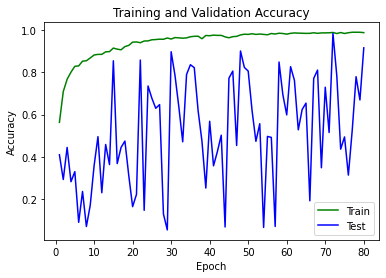

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training_Acc')
plt.plot(epochs, val_acc, color='blue', label='Validation_Acc')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.savefig("D:/Anil/saved_model/SACNN/accuracy_graph_tain_val_hsv_ResNet_adam_80epochs.png", bbox_inches="tight", pad_inches=2)
plt.show()

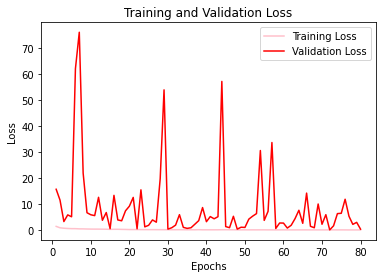

In [12]:
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train_loss', 'Val_loss'], loc='best')
plt.legend()

plt.savefig("D:/Anil/saved_model/SACNN/loss_graph_train_val_ResNet50_hsv_adam_80epochs.png", bbox_inches="tight", pad_inches=2)
plt.show()


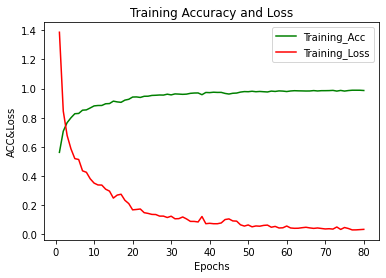

In [13]:
#loss plot
plt.plot(epochs, acc, color='green', label='Training_Acc')
plt.plot(epochs, loss, color='red', label='Training_Loss')
plt.title('Training Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('ACC&Loss')
plt.legend(['Acc', 'Loss'], loc='best')
plt.legend()

plt.savefig("D:/Anil/saved_model/SACNN/train_accuracy_loss_graph_hsv_ResNet50_adam_80epochs.png", bbox_inches="tight", pad_inches=2)
plt.show()


In [ ]:
import numpy as np
img_width = 256
img_height = 256
img = "D:/Anil/Dataset/tomato/test_imgs/early_blight.7.jpg"
img = image.load_img(img, target_size=(img_width, img_height))
img = image.img_to_array(img)
# img = img/255.0
img = rgb2hsv(img)
img = np.expand_dims(img, axis=0)
# print(images)
# np.save("D:/Anil/Dataset/test", images)
# stack up images list to pass for prediction
images = np.reshape(img,[1,256,256,3])
# images = np.vstack(img)

In [ ]:
pred = model.predict(images)
print(pred)

In [14]:
# testing of model
test_data_dir = 'D:/Anil/Dataset/tomato/test_imgs'
batch_size = 32
img_width, img_height = 224, 224


In [15]:
def gen_image_label(directory):
    ''' A generator that yields (label, id, jpg_filename) tuple.'''
    for root, dirs, files in os.walk(directory):
        for f in files:
            _, ext = os.path.splitext(f)
            if ext != '.jpg':
                continue
            basename = os.path.basename(f)
            splits = basename.split('.')
            if len(splits) == 3:
                label, id_, ext = splits
            else:
                label = None
                id_, ext = splits
            fullname = os.path.join(root, f)
            yield label, int(id_), fullname
            

In [16]:
# Wrap testing data into pandas' DataFrame.
lst = list(gen_image_label(test_data_dir))
test_df = pd.DataFrame(lst, columns=['label', 'id', 'filename'])
test_df = test_df.sort_values(by=['label', 'id'])
test_df['label_code'] = test_df.label.map({'bacterial_spot': 0, 'early_blight': 1, 'fusarium_wilt': 2, 'healthy': 3, 
                                           'late_blight': 4, 'leaf_mold': 5, 'mosaic_virus': 6, 'septoria_leaf_spot': 7, 
                                           'spider_mites': 8, 'target_spot': 9, 'yellow_leaf_curl_virus': 10})

test_df.head(100)

,label,id,filename,label_code
124,bacterial_spot,23,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
148,bacterial_spot,37,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
152,bacterial_spot,39,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
157,bacterial_spot,41,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
160,bacterial_spot,46,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
...,...,...,...,...
205,bacterial_spot,882,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
206,bacterial_spot,883,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
207,bacterial_spot,908,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
208,bacterial_spot,934,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0


In [17]:
Y_true = test_df.label_code
print(Y_true)

124      0
148      0
152      0
157      0
160      0
        ..
1890    10
1891    10
1892    10
1893    10
1895    10
Name: label_code, Length: 1948, dtype: int64


In [18]:
# No need to run again once the file save in computer
import numpy as np
img_width = 224
img_height = 224
images = []
for img in test_df.filename:
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = rgb2hsv(img)
#     img = img/255.0
    img = np.expand_dims(img, axis=0)
    images.append(img)
# print(images)
# np.save("D:/Anil/Dataset/ageng_conf/test_imgs_299x299", images)
# stack up images list to pass for prediction
images = np.vstack(images)


In [21]:
model_path = "D:/Anil/saved_model/SACNN/ResNet50_tomato_hsv_adam_80_epochs.hdf5"
model = load_model(model_path)

In [22]:
from datetime import datetime
test_start = datetime.now()
Y_pred = model.predict(images, batch_size=8)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# classes = model.predict_classes(images, batch_size=8)
print(Y_pred_classes)
test_finish = datetime.now()
test_time = test_finish - test_start
print(test_time)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[ 0  0  0 ... 10 10 10]
0:00:05.191527


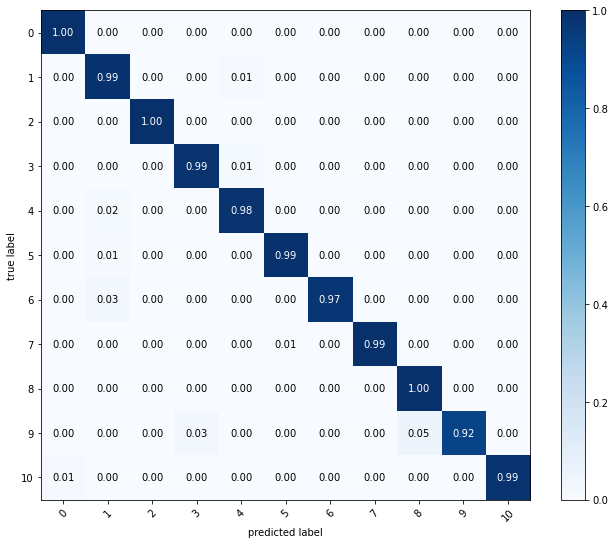

In [23]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cls_name = ['0','1','2','3','4','5','6','7','8','9','10']

ytrue = Y_true.values.flatten()
cm = confusion_matrix(ytrue, Y_pred_classes)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                figsize = (11,9),
                               show_absolute=False,
                               show_normed=True,
                               colorbar=True,
                               class_names = cls_name)
plt.show()
# print(cm)

In [24]:
fig.savefig("D:/Anil/saved_model/SACNN/confusion_matrix_ResNet50_hsv_saved_adam_best_model.png", bbox_inches = 'tight', dpi = 600)


In [25]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       214
           1       0.94      0.99      0.97       100
           2       1.00      1.00      1.00       123
           3       0.98      0.99      0.98       160
           4       0.98      0.98      0.98       192
           5       0.99      0.99      0.99        96
           6       1.00      0.97      0.99        38
           7       1.00      0.99      1.00       178
           8       0.95      1.00      0.98       169
           9       1.00      0.92      0.96       141
          10       1.00      0.99      0.99       537

    accuracy                           0.99      1948
   macro avg       0.98      0.98      0.98      1948
weighted avg       0.99      0.99      0.99      1948



In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_true, Y_pred_classes)

0.9861396303901437